# Assignment 3 Math Foundations Machine Learning
## David Alvear 187594

In [63]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import scipy as sp
from scipy.signal import convolve2d

## 1.Eigenfaces with truncated SVD

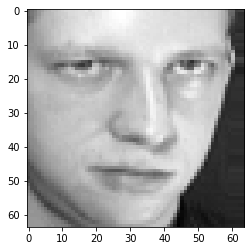

In [2]:
df = pd.read_csv('../data/face_data.csv')
A = df.iloc[:,:4096].to_numpy().transpose()

# display the 10th image in the data set
imag = A[:, 9].reshape((64,64))
plt.imshow(imag, cmap='gray')
plt.show()

In [25]:
# compute the mean and substract to the data
rows_mean = A.mean(axis=0)
A = A - rows_mean

In [26]:
A.shape

(4096, 400)

In [27]:
# Compute SVD
U, S, VT = np.linalg.svd(A)

In [28]:
print(f"Shape U:{U.shape}, S:{S.shape} VT:{VT.shape}")

Shape U:(4096, 4096), S:(400,) VT:(400, 400)


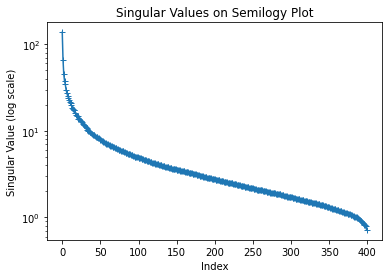

In [29]:
plt.semilogy(S, marker='+')
plt.title("Singular Values on Semilogy Plot")
plt.xlabel("Index")
plt.ylabel("Singular Value (log scale)")
plt.show()

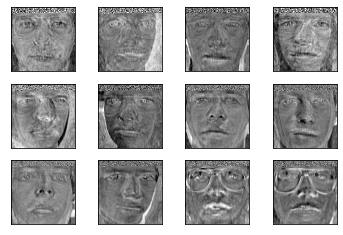

In [34]:
plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1, xticks=[], yticks=[])
    image = U[i, :].reshape((64,64))
    plt.imshow(image, cmap='gray')

- The first singular vectors capture the most significant patterns in the images.
- On each eigenface we can see that caputure a key feature, like glasses face orientation of the face.
- The first eigenfaces capture the essential information of the faces, and each singular vector capture a key feature that is significant in the faces.

In [42]:
def truncate_svd(k, A, U, S, VT):
    U_k = U[:,:k]
    S_k = np.diag(S[:k])
    VT_k = VT[:k,:]
    A_approx = np.dot(U_k, np.dot(S_k, VT_k))
    # Calculate error of approximation
    S_sq = np.dot(S[k:], S[k:]).sum()
    m, n = A.shape
    rmse = np.sqrt(S_sq/(m*n))
    return rmse

In [72]:
truncate_svd(50, A, U, S, VT)

0.049258942228112994

Taking the first 50 singular vectors and values we can approximate the matrix A with a RMSE of 4.93%

In [78]:
# Select faces
faces = A[:,:5]
faces.shape
# get truncated U
U_k = U[:,:50]
# compute approximation
y = np.dot(U_k.T, faces)
reconstructed_faces = np.dot(U_k, y)
print(f"Error of reconstructed: {np.linalg.norm(faces - reconstructed_faces, axis=1)}")

Error of reconstructed: [0.14749549 0.14072187 0.09538725 ... 0.08330084 0.06030309 0.09244079]


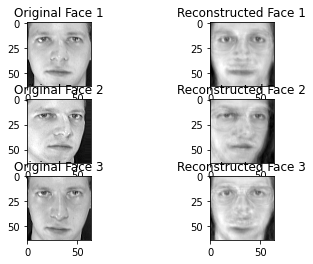

In [66]:
for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(faces[:,i].reshape(64, 64), cmap='gray')
    plt.title(f"Original Face {i+1}")

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(reconstructed_faces[:,i].reshape(64, 64), cmap='gray')
    plt.title(f"Reconstructed Face {i+1}")

plt.show()

The dimension of the original images is 4096. Using SVD can we represent the image with 50 values and still get a good approximation of the original image. The reconstructed images are legible and contain the relevant structures and representations of the original image. This implies that the k=50 elements in the U singular vector matrix contains the most significant information of the images and represent the most important variability of the data. If we add more elements we can improve the quality of the reconstruction.

## 2. Embedding via SVD

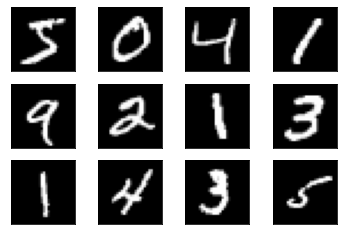

In [19]:
# read MNIST training data
df = pd.read_csv('../data/mnist_train.csv')
df_test = pd.read_csv("../data/mnist_test.csv")
# df = pd.concat([df_train, df_test]).reset_index(drop=True)
data = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
labels = df.iloc[:, 0].to_numpy()                # labels of images
train_data = (data - data.mean(axis=0))

# plot the first dozen images from the data set
plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1, xticks=[], yticks=[])
    image = data[i, :].reshape((28,28))
    plt.imshow(image, cmap='gray')

In [18]:
# compute SVD
# U, S, VT = np.linalg.svd(train_data[:,:6000].T) 
# Apply Truncated SVD
svd = TruncatedSVD(n_components=50)
data_svd = svd.fit_transform(train_data.T)

In [21]:
reconstructed_svd = svd.inverse_transform(data_svd)
error = np.linalg.norm(train_data.T - reconstructed_svd, axis=1)
rmse = np.sqrt(np.mean(np.square(error)))

In [25]:
reconstructed_svd.shape

(784, 60000)

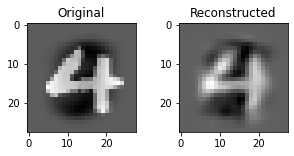

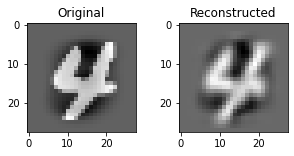

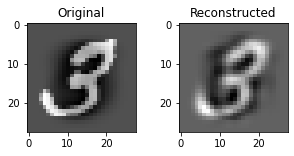

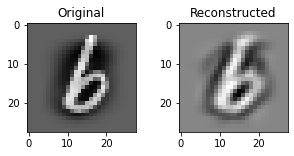

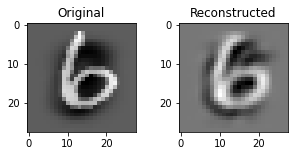

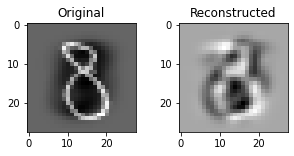

In [26]:
n_examples = 6
random_idx = np.random.randint(0, train_data.shape[0], n_examples)

# Plot original and reconstructed images
for idx in random_idx:
    plt.figure(figsize=(5, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(train_data[idx].reshape(28, 28), cmap='gray')
    plt.title('Original')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_svd.T[idx].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    
    plt.show()

In [27]:
# Calculate RMSE
rmse = np.sqrt(((train_data - reconstructed_svd.T) ** 2).mean())
print(f"Overall RMSE: {rmse}")

Overall RMSE: 0.10863249676541047


The truncated SVD capture the most important information in the data using fewer dimensions. The quality of the classifier depends on how well the k=50 dimensional representation capture the significant features in the dataset. If the 50 singular values capture the most essential data variability the resulted confussion matrix will be comparable in class discrimination producing a similar confusion matrix. Then, it's likely that the classifier would perform reasonably well with a lower-dimensional space representation.

## 3. Spectral clustering

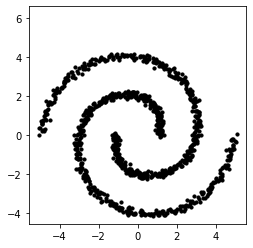

In [28]:
def sample_spiral():
    points_per_cluster = 500
    bandwidth = 0.1
    data = np.empty((points_per_cluster, 2))
    w = np.arange(1, points_per_cluster + 1).astype(np.float32) / points_per_cluster
    data[:,0] = (4 * w + 1) * np.cos(2*np.pi * w) + np.random.randn(points_per_cluster) * bandwidth
    data[:,1] = (4 * w + 1) * np.sin(2*np.pi * w) + np.random.randn(points_per_cluster) * bandwidth
    data = np.vstack((data, -data))
    return data

X = sample_spiral()
N = X.shape[0]

plt.scatter(X[:, 0], X[:, 1], s = 10, c = 'k')
plt.axis('square')
plt.show()

# if y is the assignment of the N points to clusters 0 and 1, then plot as
# plt.scatter(X[:, 0], X[:, 1], s = 10, c = y)


# scaling paramater (we may want to try different values and select the least-distored clusters)



# YOUR CODE GOES HERE

### K-means

In [33]:
###################################
######### K-means #################
###################################

class kmeans:
    def __init__(self, x, k, maxiters = 30, tol = 1e-4):
        self.maxiters = maxiters
        self.tol = tol
        self.x = x
        self.k = k
    
    def clustering(self):
        N, d = self.x.shape
        distances = np.zeros(N) 
        initial = np.random.choice(N, self.k, replace=False) # select random initial 
        reps = self.x[initial, :] # Get the representatives from x
        assignment = np.zeros(N, dtype = np.int32) # to store the groupd
        Jprev = np.infty
        J_list = []
        for iter in range(self.maxiters):
            # Find distance to neares representative and group index
            for i in range(N):
                ci = np.argmin([np.linalg.norm(self.x[i] - reps[j]) for j in range(self.k)])
                assignment[i] = ci
                distances[i] = np.linalg.norm(self.x[i] - reps[ci])
                
            # cluster j representative
            for j in range(self.k):
                group = [i for i in range(N) if assignment[i] == j]
                reps[j] = np.sum(self.x[group], axis=0) / len(group)
                
            # compute clustering objective
            J = np.linalg.norm(distances) ** 2 /N
            
            # convergence
            if (iter > self.maxiters) or (np.abs(J - Jprev) < self.tol*J):
                break
            Jprev = J
            J_list.append(J) # Store the J value
        
        return Jprev, assignment, reps, J_list # return J, assignments of x, representatives
    
    def iterative_clustering(self, run_budget):
        # perform k-means multiple times
        kmeans_results = []
        best_J = np.infty
        index_kmeans = 0
        for i in range(run_budget):
            run = self.clustering() # J, assignment, rep
            kmeans_results.append(run)
            # check if model is better
            if run[0] < best_J: # if new J is better than last best
                best_J = run[0]
                index_kmeans = i # Get the index of the best model so far
        # store best model
        self.result_best_kmeans = kmeans_results[index_kmeans]
        return pd.DataFrame(kmeans_results) # list of runs


In [34]:
# initialize kmeans model
kmeans_model = kmeans(X, 2)
results_kmeans = kmeans_model.iterative_clustering(run_budget=3)
best_result = kmeans_model.result_best_kmeans
print(f"Best Result index:{np.argmin(results_kmeans[0].to_numpy())}")

Best Result index:0


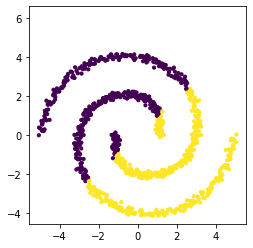

In [36]:
# plot 3d clustering for iris dataset
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s = 10, c = best_result[1])
plt.axis('square')
plt.show()

In [45]:
class SpectralClustering:
    def __init__(self, X, k, sigma=1.0):
        self.X = X
        self.k = k
        self.sigma = sigma

    def fit(self, run_budget=3):
        self.W = self.gaussian_similarity_matrix()
#         self.L = unnormalized_laplacian(self.W)
        self.L_norm = self.normalized_laplacian(self.W)
        Y_normalized = self.eigendecomposition(self.L_norm)
        self.kmeans_model = kmeans(Y_normalized, self.k)
        self.results_kmeans = self.kmeans_model.iterative_clustering(run_budget=3)
        return self.kmeans_model.result_best_kmeans
        
    def low_rank_decompose(self):
        # U, S, VT
        self.W, S, VT = np.linalg.svd(self.X.T) # transpose of the data
        self.ZT = np.dot(S, VT) # projected points or PC scores ZT = UT.XT
    
    def gaussian_similarity_matrix(self):
        # Compute the similarity matrix
        n_samples = self.X.shape[0]
        W = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                similarity = np.exp(-np.linalg.norm(self.X[i] - self.X[j])**2 / (2.0 * self.sigma**2))
                W[i, j] = similarity
                W[j, i] = similarity
        return W
    
    def unnormalized_laplacian(self, W):
        # Calculate the degree matrix D
        D = np.diag(np.sum(W, axis=1))
        # Calculate the Laplacian matrix L
        L = D - W
        return L
    
    def normalized_laplacian(self, W):
        # Calculate the degree matrix D
        D = np.diag(np.sum(W, axis=1))

        # Calculate D^{-1/2}
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))

        # Calculate the normalized Laplacian
        L_norm = np.identity(W.shape[0]) - np.dot(D_inv_sqrt, np.dot(W, D_inv_sqrt))

        return L_norm
    
    def eigendecomposition(self, L):
        eigenvalues, eigenvectors = np.linalg.eig(L)
        sorted_indices = np.argsort(eigenvalues)

        chosen_indices = sorted_indices[:self.k]
        Y = eigenvectors[:, chosen_indices]
        Y_normalized = Y / np.linalg.norm(Y, axis=1, keepdims=True)
        return Y_normalized


In [46]:
sigma = 0.1
spec_clustering = SpectralClustering(X, 2, sigma)
best_result_spectral = spec_clustering.fit()

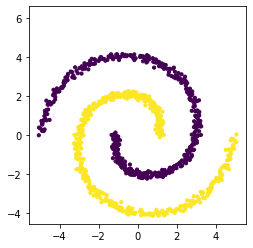

In [47]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s = 10, c = best_result_spectral[1])
plt.axis('square')
plt.show()

### Comments

Spectral clustering divides the two spirals into distinct clusters. The method's effectiveness lies in several key aspects. First, we create a similarity matrix that encapsulates the distances between each pair of points, generating a similarity graph. Then, the Laplacian matrix is calculated to capture the topology of this graph. By computing the eigenvalues and their corresponding eigenvectors, we are able to quantify the frequency components of the graph. In other words, it projects the similarity graph into a lower-dimensional space while preserving its critical structural information. Finally, by sorting the k smallest eigenvalues and their corresponding eigenvectors, we identify the most efficient way with minimum cost to partition the graph into k clusters. This partitioning is then completed using a traditional clustering algorithm like k-means.

## 4. 2D convolutions

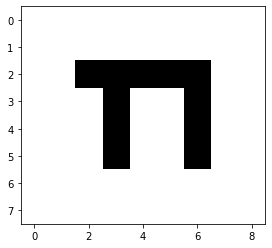

In [50]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 0, 0, 0, 0, 0, 1, 1],
             [1, 1, 1, 0, 1, 1, 0, 1, 1],
             [1, 1, 1, 0, 1, 1, 0, 1, 1],
             [1, 1, 1, 0, 1, 1, 0, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1]])


plt.imshow(X, cmap='gray')

In [66]:
###################################
######### Kernels #################
###################################
B1 = np.array([[0.25, 0.25], [0.25, 0.25]])
B2 = np.array([[-1.0, 1.0]])
B3 = np.array([[-1.0], [1.0]])  # Or B3 = B2.T
B4 = np.array([[-1.0, 2.0, -1.0], [-1.0, 2.0, -1.0]])
B5 = np.array([[-1.0, -1.0], [2.0, 2.0], [-1.0, -1.0]])

B = [B1, B2, B3, B4, B5]

def image_convolve_2d(X, kernel):
    Y = convolve2d(X, kernel, mode='same')
    return Y

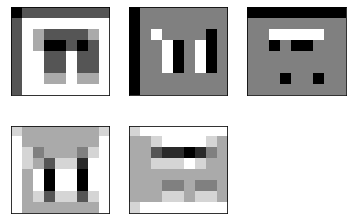

In [67]:
plt.figure()
for i in range(5):
    plt.subplot(2, 3, i+1, xticks=[], yticks=[])
    image = image_convolve_2d(X, B[i])
    plt.imshow(image, cmap='gray')

### Comments

- Kernel B1 compute implement an average filter smoothing the borders of the figure.
- Kernel B2 is a filter to detect vertical edges
- Kernel B3 Detect howizongal edges
- Kernel B4 is designed to detect strong vertical edges in the image with a large ourput value in that cases
- Kernel B5 is a filter to detect strong horizontal edges with a large ouput value in that cases
- The larger values captured in the convolution are when kernels B4 and B5 are used